<a href="https://colab.research.google.com/github/dsaranya885-debug/XAI-time-series-/blob/main/Copy_of_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

def generate_dataset(timesteps=800, seed=42):
    np.random.seed(seed)

    time = np.arange(timesteps)

    sensor_A = np.sin(time/15) + np.random.normal(0, 0.1, timesteps)
    sensor_B = np.cos(time/20) + np.random.normal(0, 0.1, timesteps)
    sensor_C = np.random.normal(0, 1, timesteps).cumsum() / 50  # non-stationary drift

    target = (
        0.5*sensor_A +
        0.3*sensor_B +
        0.2*sensor_C +
        np.random.normal(0, 0.05, timesteps)
    )

    df = pd.DataFrame({
        "time": time,
        "sensor_A": sensor_A,
        "sensor_B": sensor_B,
        "sensor_C": sensor_C,
        "target": target
    })

    df.to_csv("time_series_dataset.csv", index=False)
    print("Dataset saved as time_series_dataset.csv")

    return df

df = generate_dataset()
print(df.head())

Dataset saved as time_series_dataset.csv
   time  sensor_A  sensor_B  sensor_C    target
0     0  0.049671  1.093828 -0.003658  0.316166
1     1  0.052791  0.947146  0.023840  0.324148
2     2  0.197707  1.004616  0.010920  0.375089
3     3  0.350972  0.942544 -0.005064  0.443654
4     4  0.240102  0.936617 -0.014718  0.481765


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(df):
    df = df.copy()

    # Introduce missing values artificially (for training practice)
    df.iloc[50:55, 1] = np.nan
    df.iloc[200:202, 2] = np.nan

    # Fill missing values
    df = df.fillna(method="ffill").fillna(method="bfill")

    # Scale all features except time
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df.drop("time", axis=1))

    df_scaled = pd.DataFrame(scaled, columns=df.columns[1:])
    df_scaled["time"] = df["time"]

    return df_scaled, scaler

df_scaled, scaler = preprocess_data(df)
print(df_scaled.head())

   sensor_A  sensor_B  sensor_C    target  time
0  0.507730  0.956130  0.045978  0.602362     0
1  0.508898  0.894891  0.086940  0.606604     1
2  0.563152  0.918884  0.067695  0.633672     2
3  0.620531  0.892969  0.043885  0.670106     3
4  0.579023  0.890495  0.029502  0.690358     4


/tmp/ipython-input-4070123873.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


In [ ]:
import numpy as np

def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, -1])  # target is last column
    return np.array(X), np.array(y)

# Convert DataFrame to numpy
values = df_scaled.drop("time", axis=1).values

SEQ_LEN = 30
X, y = create_sequences(values, seq_len=SEQ_LEN)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X shape: (770, 30, 4)
y shape: (770,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def build_lstm_model(seq_len, n_features):
    model = tf.keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=(seq_len, n_features)),
        layers.LSTM(32),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

model = build_lstm_model(SEQ_LEN, X.shape[2])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.2027 - mae: 0.3730 - val_loss: 0.0210 - val_mae: 0.1217
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0244 - mae: 0.1297 - val_loss: 0.0176 - val_mae: 0.1121
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0139 - mae: 0.0993 - val_loss: 0.0117 - val_mae: 0.0915
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0086 - mae: 0.0759 - val_loss: 0.0050 - val_mae: 0.0579
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0036 - mae: 0.0484 - val_loss: 0.0021 - val_mae: 0.0379
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0028 - mae: 0.0425 - val_loss: 0.0029 - val_mae: 0.0425
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0024 - mae: 0.0395 - val_loss: 0.0021 - val_mae: 0.0383
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0022 - mae: 0.0377 - val_loss: 0.0022 - val_mae: 0.0375
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.001

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)

y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - mae: 0.0393
Test Loss: 0.002041060011833906
Test MAE: 0.03659817948937416
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------------------------
# 1. Load dataset
# ------------------------------------------------
df = pd.read_csv("time_series_dataset.csv")
df = df[["sensor_A", "sensor_B", "sensor_C", "target"]]

# ------------------------------------------------
# 2. Create Lag Features
# ------------------------------------------------
def create_lags(df, n_lags=5):
    data = df.copy()
    for i in range(1, n_lags+1):
        data[f"lag_{i}"] = data["target"].shift(i)
    return data

df_lag = create_lags(df, n_lags=5).dropna()

# ------------------------------------------------
# 3. Train/Test Split
# ------------------------------------------------
train_size = int(len(df_lag) * 0.8)

X = df_lag.drop("target", axis=1)
y = df_lag["target"]

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ------------------------------------------------
# Helper Function: Train + Evaluate
# ------------------------------------------------
def evaluate(model, name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    print(f"\n===== {name} =====")
    print("MSE:", mse)
    print("MAE:", mae)
    return pred

In [ ]:
pred_lr = evaluate(LinearRegression(), "Linear Regression")


===== Linear Regression =====
MSE: 0.002433979020849877
MAE: 0.03992683033430543


In [ ]:
pred_ridge = evaluate(Ridge(alpha=1.0), "Ridge Regression")


===== Ridge Regression =====
MSE: 0.0024183627005477425
MAE: 0.03976186673113746


In [ ]:
pred_lasso = evaluate(Lasso(alpha=0.001), "Lasso Regression")


===== Lasso Regression =====
MSE: 0.0024378251920113727
MAE: 0.03966197687829351


In [ ]:
pred_elastic = evaluate(ElasticNet(alpha=0.001, l1_ratio=0.5),
                        "Elastic Net Regression")


===== Elastic Net Regression =====
MSE: 0.002408820448968184
MAE: 0.03946809073994622


In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

svr = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.01)
pred_svr = evaluate(svr, "Support Vector Regression (SVR)")



===== Support Vector Regression (SVR) =====
MSE: 0.0028545040057787077
MAE: 0.04200318880159188


In [ ]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

pred_poly = model_poly.predict(X_test_poly)

print("\n===== Polynomial Regression (Degree 3) =====")
print("MSE:", mean_squared_error(y_test, pred_poly))
print("MAE:", mean_absolute_error(y_test, pred_poly))


===== Polynomial Regression (Degree 3) =====
MSE: 0.0035365282627833794
MAE: 0.04735195944624787


In [ ]:
rf = RandomForestRegressor(n_estimators=200)
pred_rf = evaluate(rf, "Random Forest Regression")


===== Random Forest Regression =====
MSE: 0.006427334655083206
MAE: 0.06375651125977781


In [ ]:
gbr = GradientBoostingRegressor(n_estimators=200)
pred_gbr = evaluate(gbr, "Gradient Boosting Regression")


===== Gradient Boosting Regression =====
MSE: 0.0049770460791933755
MAE: 0.056757190803664724


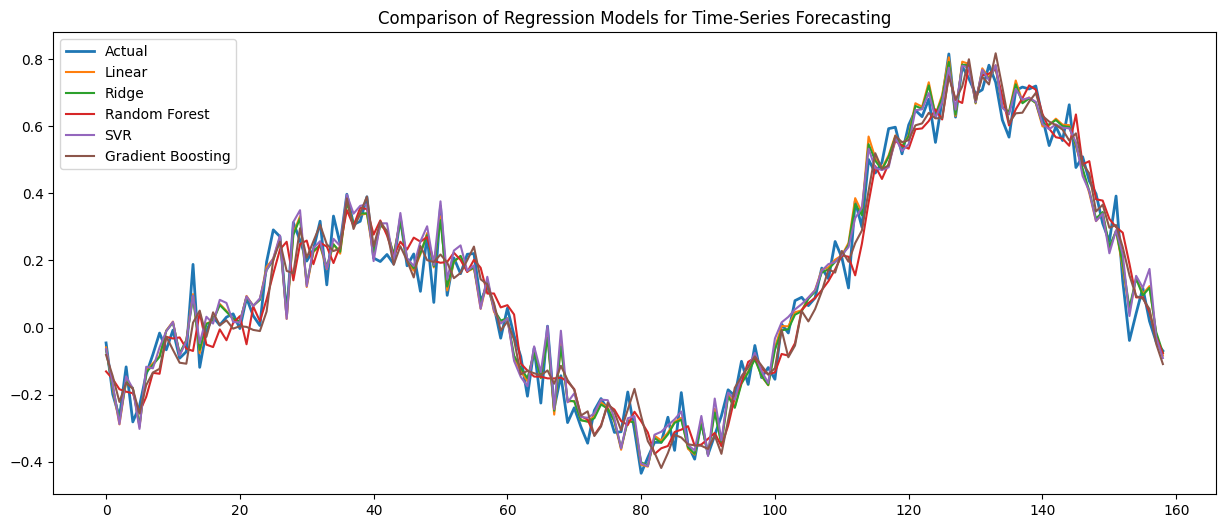

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y_test.values, label="Actual", linewidth=2)

plt.plot(pred_lr, label="Linear")
plt.plot(pred_ridge, label="Ridge")
plt.plot(pred_rf, label="Random Forest")
plt.plot(pred_svr, label="SVR")
plt.plot(pred_gbr, label="Gradient Boosting")

plt.title("Comparison of Regression Models for Time-Series Forecasting")
plt.legend()
plt.show()